# 8. Predictive Modeling

## 8.0 Imports

In [1]:
#standard imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# special imports
import warnings


#specific libaries
import glob 
    # read all csv files in the directory
    # documentation: https://docs.python.org/3/library/glob.html#glob.glob
import time
    # converting int/unix representation of Dates to DateTime Format

#ML - PreProcessing
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#ML - Models and Grids 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC


#Output and Validation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
%matplotlib inline
#reset -f #cleaning the namespace / self assigned variables

warnings.filterwarnings('ignore') #for suppression of depricated messages
RSEED = 42       #for replicability purposes
sns.set(style="white")  #default plot styling 

#Modeling
scoring = "f1"

## 8.5 Importing  'df_model' from Pickle

In [3]:
savepath = 'df_model.pkl'
df_model = pd.read_pickle(savepath)

In [4]:
df_model.shape

(132238, 16)

In [5]:
df_model.head().T

,137407,110127,75542,90415,48562
country,US,CA,FR,US,US
currency,USD,CAD,EUR,USD,USD
staff_pick,0,0,0,0,0
usd_goal,30000,4373.09,2178.67,20000,6000
success,1,1,1,1,1
total_category,Fashion//Apparel,Film & Video//Documentary,Crafts//Crafts,Publishing//Periodicals,Games//Video Games
duration_days,44,55,30,30,29
launch_hour,14,15,16,18,1
launch_day,Tuesday,Tuesday,Tuesday,Wednesday,Tuesday
launch_month,February,December,May,March,February


## 8.6 One Hot Encoding

In [6]:
lst = ['currency',
        'country',
        'total_category',
        'launch_day',
        'launch_month',
        'deadline_day', 
        'deadline_month']
df_model = pd.get_dummies(df_model,prefix_sep='&', columns=lst, drop_first=True)

In [7]:
list(df_model.columns)[10:21]

['currency&CHF',
 'currency&DKK',
 'currency&EUR',
 'currency&GBP',
 'currency&HKD',
 'currency&JPY',
 'currency&MXN',
 'currency&NOK',
 'currency&NZD',
 'currency&SEK',
 'currency&SGD']

## 8.7 Creating 'df_reduced' from 'df_model'

The process of understanding, implementing and optimizing various models can be tedious. The time needed for training models is greatly influenced by the number of observations. In this chapter a `df_reduced` is shaped and introduced. The reduced dataframe can be used to get the models up&running. The actual evaluation shall then later be done using the df_model. 

In [8]:
df_unreduced = df_model.copy()

In [9]:
df_unreduced.shape

(132238, 245)

In [10]:
df_unreduced['success'].value_counts()

1    66119
0    66119
Name: success, dtype: int64

In [11]:
df_unreduced_1 = df_unreduced[df_unreduced.success==1]
df_unreduced_0 = df_unreduced[df_unreduced.success==0]

df_reduced_1 = resample(df_unreduced_1,
                        replace=False,      # sample without replacement
                        n_samples=3000,      # to match minority class
                        random_state=RSEED) # reproducible results

df_reduced_0 = resample(df_unreduced_0,
                        replace=False,      # sample without replacement
                        n_samples=3000,      # to match minority class
                        random_state=RSEED) # reproducible results

df_reduced = pd.concat([df_reduced_1, df_reduced_0])

df_reduced['success'].value_counts()

1    3000
0    3000
Name: success, dtype: int64

## 8.8 Support Functions

In [12]:
# Print Scores
def print_scores(y_test, y_pred):
    '''
    Function to print the f1, accuracy, precision, recall and ROC-AUC score. 
    '''
    print(classification_report(y_test,y_pred),'\n')
    print('f1_score:        ',round(f1_score(y_test,y_pred),3))
    print('accuracy_score:  ',round(accuracy_score(y_test,y_pred),3))
    print('precision_score: ',round(precision_score(y_test,y_pred),3))
    print('recall_score:    ',round(recall_score(y_test,y_pred),3))
    print('roc_auc_score:   ',round(roc_auc_score(y_test,y_pred),3))
    print('\n')


# Confusion Matrix
def confu_matrix(y_test, y_pred):
    '''
    Printed SNS Heatmap Conusion Matrix
    '''
    conf_mat = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(conf_mat, annot=True, cmap='Blues',fmt=".0f");
      
# Output
def show_all_results(y_test,y_pred):
    '''
    Wrapper Function to print scores, errors and the confusion matrix
    '''
    print_scores(y_test, y_pred)
    confu_matrix(y_test, y_pred)

## 8.9 Train Test Split & Feature Scaling

In [13]:
#label to be predicted 
success = np.array(df_model.pop('success'))
success_r = np.array(df_reduced.pop('success'))

As described above, `df_reduced` is a reduced dataframe for testing and development purposes. In the process of developing models `X_train_r, X_test_r, y_train_r, y_test_r` are reduced train-test sets. 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_model, success, 
                                                    test_size=0.25,
                                                    random_state=RSEED,
                                                    stratify=success)

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(df_reduced, success_r, 
                                                    test_size=0.25,
                                                    random_state=RSEED,
                                                    stratify=success_r)

In [15]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print(X_train_r.shape, y_train_r.shape)
print(X_test_r.shape, y_test_r.shape)

(99178, 244) (99178,)
(33060, 244) (33060,)
(4500, 244) (4500,)
(1500, 244) (1500,)


4 Models are implemented and evaluated: 
- Logistic Regression (base model)
- XGBoost
- SVM
- RandomForrest

**Feature Scaling**

In [16]:
sc = StandardScaler()
X_train_non_scaled = X_train #preservered X_test and X_train dataframe for plotting purposes 
X_test_non_scaled = X_test #preservered X_test and X_train dataframe for plotting purposes 
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

## 8.10 Logistic Regression (base model)

In [17]:

# Create the model
lr = LogisticRegression()

# Fit on training data
lr.fit(X_train, y_train)

# Make the predictions for X_test
y_pred_lr = lr.predict(X_test)

              precision    recall  f1-score   support

           0       0.76      0.88      0.81     16530
           1       0.86      0.72      0.78     16530

    accuracy                           0.80     33060
   macro avg       0.81      0.80      0.80     33060
weighted avg       0.81      0.80      0.80     33060
 

f1_score:         0.78
accuracy_score:   0.798
precision_score:  0.856
recall_score:     0.717
roc_auc_score:    0.798




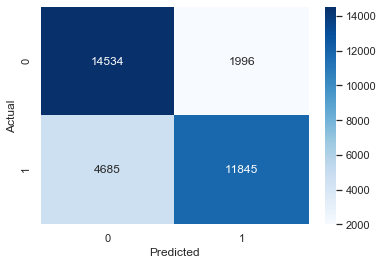

In [18]:
#### --- OUTPUT ----  ####
show_all_results(y_test, y_pred_lr)

## 8.11 XGBoost

In [19]:

# Create the model
xgb = XGBClassifier()

# Fit on training data
xgb.fit(X_train, y_train)

# Make the predictions for X_test
y_pred_xgb = xgb.predict(X_test)

              precision    recall  f1-score   support

           0       0.79      0.89      0.83     16530
           1       0.87      0.76      0.81     16530

    accuracy                           0.82     33060
   macro avg       0.83      0.82      0.82     33060
weighted avg       0.83      0.82      0.82     33060
 

f1_score:         0.81
accuracy_score:   0.823
precision_score:  0.87
recall_score:     0.758
roc_auc_score:    0.823




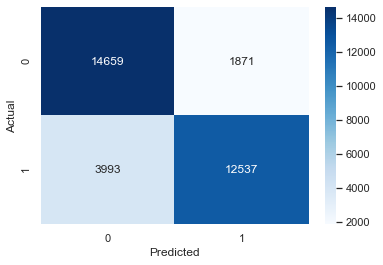

In [20]:
#### --- OUTPUT ----  ####
show_all_results(y_test,y_pred_xgb)

## 8.12 SVM

SVM is computational demanding, especially with such many observations as given in the current task. Hence, SVM is here only described using the reduced train-test-set. Note however, that the SVM is performing very poor and hence further investigation is not done. 

In [21]:

# Create the model
svc = SVC(kernel='rbf') #, C=2000)

# Fit on training data
svc.fit(X_train_r, y_train_r)

# Make the predictions for X_test
y_pred_svc_r = svc.predict(X_test_r)

              precision    recall  f1-score   support

           0       0.76      0.26      0.39       750
           1       0.55      0.91      0.69       750

    accuracy                           0.59      1500
   macro avg       0.65      0.59      0.54      1500
weighted avg       0.65      0.59      0.54      1500
 

f1_score:         0.69
accuracy_score:   0.589
precision_score:  0.554
recall_score:     0.915
roc_auc_score:    0.589




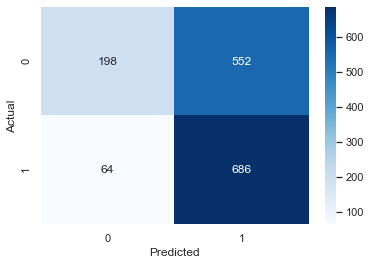

In [22]:
#### --- OUTPUT ----  ####
show_all_results(y_test_r,y_pred_svc_r)

## 8.13 Random Forest

In [23]:

rfc = RandomForestClassifier(n_estimators = 150,
                            max_depth=100, 
                            max_features = 'sqrt',
                            min_samples_leaf=3,
                            min_samples_split=10, 
                            n_jobs=-1,
                            random_state=RSEED, 
                            oob_score = True
                           ) 


# Fit on training data
rfc.fit(X_train, y_train)

y_pred_rfc = rfc.predict(X_test)

              precision    recall  f1-score   support

           0       0.79      0.89      0.83     16530
           1       0.87      0.76      0.81     16530

    accuracy                           0.82     33060
   macro avg       0.83      0.82      0.82     33060
weighted avg       0.83      0.82      0.82     33060
 

f1_score:         0.811
accuracy_score:   0.823
precision_score:  0.87
recall_score:     0.76
roc_auc_score:    0.823




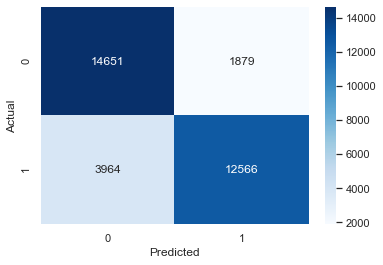

In [24]:
#### --- OUTPUT ----  ####
show_all_results(y_test, y_pred_rfc)

### 8.13.1 Feature Importance Random Forest

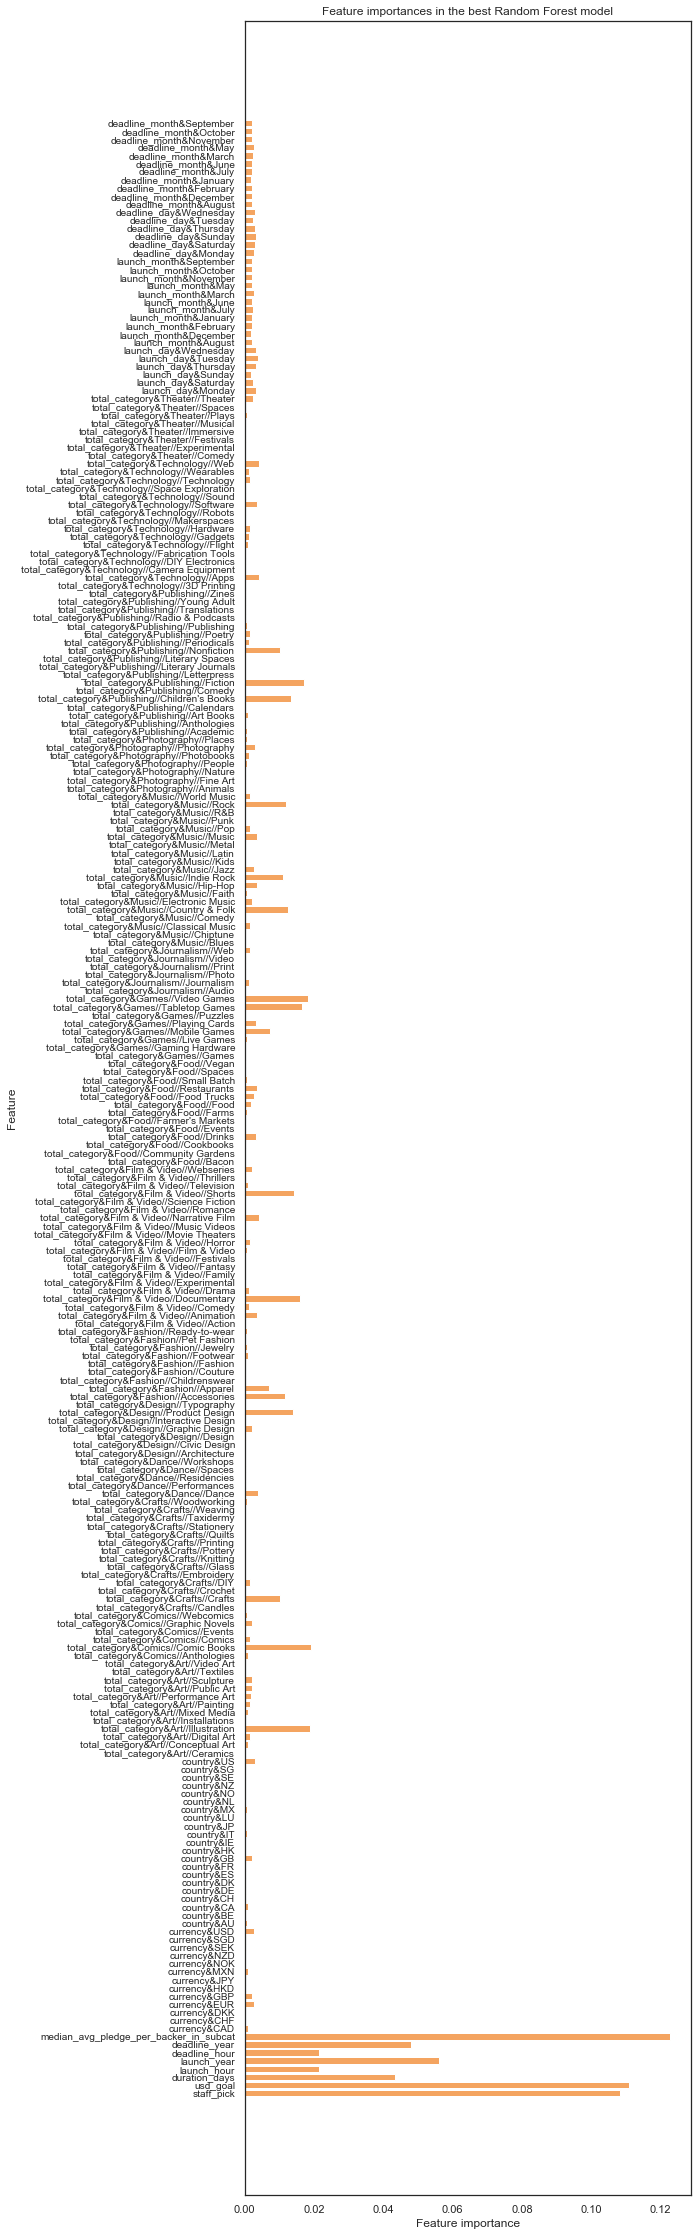

In [25]:
### Feature Importance (incl. Dummies) Vertical, readable, for investigation 
n_features = X_train.shape[1]
plt.figure(figsize=(8,40))
plt.barh(range(n_features), rfc.feature_importances_, align='center', color='sandybrown') 
plt.yticks(np.arange(n_features), X_train_non_scaled.columns.values, fontsize=10) 
plt.title("Feature importances in the best Random Forest model")
plt.xlabel("Feature importance")
plt.ylabel("Feature")
#plt.savefig('figures/FeatureImportance_All_name_RandomForest.png', transparent=True)
plt.show()

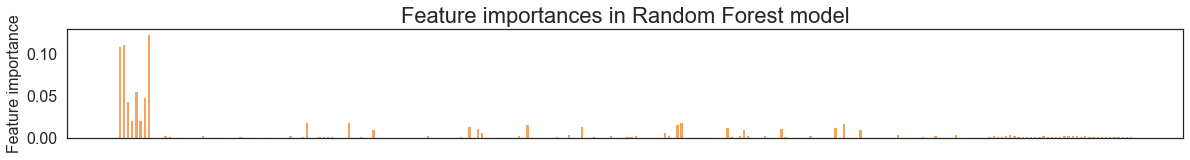

In [26]:
#### Feature Importance (incl. Dummies) Horizontal, only for visualisation of distribution
n_features = X_train.shape[1]
plt.figure(figsize=(20,2))
plt.bar(range(n_features), rfc.feature_importances_, align='center', color='sandybrown') 
plt.title("Feature importances in Random Forest model", fontsize=22)
plt.ylabel("Feature importance", fontsize=16)
plt.yticks(fontsize=16)

plt.xticks([])
plt.xlabel('')
#plt.savefig('figures/FeatureImportance_All_presentation_RandomForest.png', transparent=True)
plt.show()

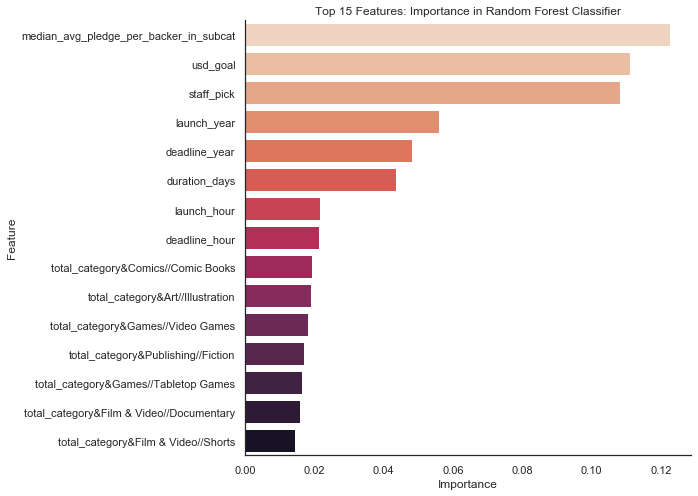

In [27]:
#### Top X Dummie-Features 
results = pd.DataFrame(list(X_train_non_scaled), rfc.feature_importances_).reset_index()
results.columns = ['Importance', 'Feature']
results = results.sort_values(by='Importance', ascending=False).head(15)

f, ax = plt.subplots(figsize=(8, 8))
sns.barplot(x=results.Importance, y=results.Feature, palette='rocket_r')
ax.set_title("Top 15 Features: Importance in Random Forest Classifier")
sns.despine()
#plt.savefig('figures/FeatureImportance_Top15_RandomForest.png', transparent=True)
plt.show()

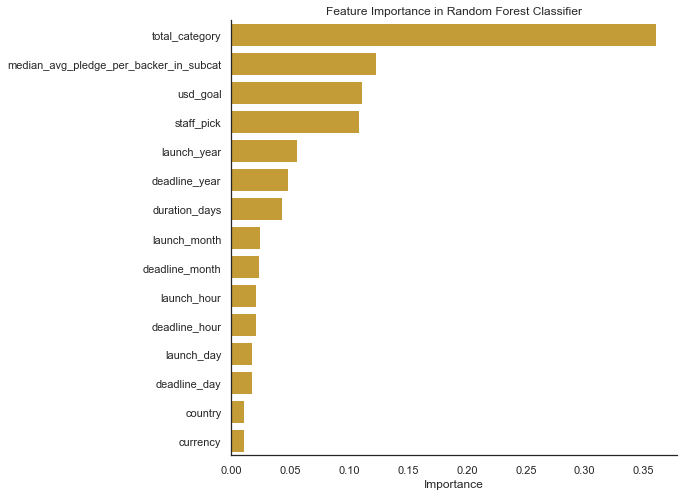

In [28]:
### Importance Main Features
results = pd.DataFrame(list(X_train_non_scaled), rfc.feature_importances_).reset_index()
results.columns = ['Importance', 'Dummie_Feature']
results = results.sort_values(by='Importance', ascending=False)

prefix_sep='&'
results['main_feature'] = results['Dummie_Feature'].apply(lambda x: x.split(prefix_sep)[0].strip())

results = results.groupby('main_feature').sum()
results['Feature'] = results.index
results = results.sort_values(by='Importance', ascending=False)

f, ax = plt.subplots(figsize=(8, 8))
sns.barplot(x=results.Importance, y=results.Feature, color='goldenrod')
ax.set_title("Feature Importance in Random Forest Classifier")
sns.despine()
plt.ylabel('')
#plt.savefig('figures/FeatureImportance_Main_RandomForest.png', transparent=True, bbox_inches='tight')
plt.show()

### 8.13.2 Random Forrest using RandomSearch

In [29]:
rfc = RandomForestClassifier(random_state=RSEED, 
                            n_jobs=-1, verbose = 0)
param_grid = {
    'n_estimators': [10, 200, 150], #number of trees in the foreset
    'max_depth': [3, 15, 100], #max number of levels in each decision tree
    'max_features': ['auto', 'sqrt'], #considered for splitting a node
    'min_samples_leaf': [3, 4, 5], # min number of data points placed in a node before the node is split
    'min_samples_split': [8, 10, 12], #min number of data points allowed in a leaf node
    'bootstrap': [True, False] # method for sampling data points (with or without replacement
            }

# Create the random search model
rs_rfc = RandomizedSearchCV(rfc, #model to evaluate on
                    param_grid, 
                    n_jobs = -1, 
                    n_iter = 1, #number of random tries in the RandomSearchGrid
                            # note: n_iter defines how long the RandomForrest is computing
                            # n_iter should be much greater then 1, e.g., 10, which will lead to high computation times
                    scoring = scoring, cv = 5, 
                    verbose = 0, random_state=RSEED)

#fitting the model
rs_rfc.fit(X_train, y_train)

#settings regarding best estimator 
print(rs_rfc.best_estimator_)
print(rs_rfc.best_params_)

RandomForestClassifier(max_depth=15, max_features='sqrt', min_samples_leaf=5,
                       min_samples_split=10, n_estimators=10, n_jobs=-1,
                       random_state=42)
{'n_estimators': 10, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 15, 'bootstrap': True}


              precision    recall  f1-score   support

           0       0.78      0.83      0.80     16530
           1       0.82      0.76      0.79     16530

    accuracy                           0.79     33060
   macro avg       0.80      0.79      0.79     33060
weighted avg       0.80      0.79      0.79     33060
 

f1_score:         0.788
accuracy_score:   0.795
precision_score:  0.816
recall_score:     0.762
roc_auc_score:    0.795




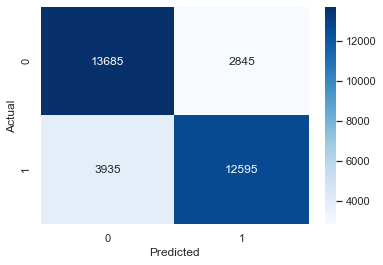

In [30]:
#using the best estimator to predict at X_test
best_rs_rfc = rs_rfc.best_estimator_
best_rs_rfc_predictions = best_rs_rfc.predict(X_test)
show_all_results(y_test,best_rs_rfc_predictions)

# 9. Conclusion

The Random Forrest model as well as the XGboost performe well for the given task with an **f1-score of 0.8**, compared to the f1 score of  0.78 of the base model (Logistic Regression). As for the features: The category has the greatest influence on the success of a project. As part of the EDA, the `median_avg_pledge_per_backer_in_subcat` feature is designed. This feature gives an understanding of how much money the average backer in an sub category is willing to back a project. This has great influence on the success rate of a project.

# 10. Data Visualization
Communicate the findings with key stakeholders using plots and interactive visualizations

- Feature Impotance for Random Forest has been visualized in 8.10.1

# 11. Future Work

- Feature Engneering: **Average USD-Pledge per Subcategory** to evaluate better supported subcategories. 
- **ROC Curve**s are another way to illustrate the performance of a specific model. Compared to the F1-Score, ROC Curves contain more information and, hence, generate a deeper understanding of the model's performance. They are especially great for investigating and comparing different models.  Besides, ROC curves are a great tool for communicating results. Hence, in future work, ROC curves should generate a deeper understanding of the model's performance. 
- The used **confusion matrix** fulfills its purpose: comparing the predicted and actual successes and failures. The color-coding is a great addition as it shows the severity of various values at a glance. Nevertheless, percentage values and labeling would be a great addition and is part of future work. 
- Aiming for the stars: The **blurb** (a string description) and the **photo** (mostly different versions of the main image) have been droped in the current analysis earlie on. Splitting the blurb into its fragments could potentially surface a corrolation between success and metaphorical, postive words. In addition, Analysing the images, e.g., for items or for color palets, could bring great insights and be a very steep but rewarding learning curve. 